# Chapter 5

In [6]:
# from os.path import dirname, join
# from dotenv import load_dotenv


# dotenv_path = join(dirname(__file__), '.env')
# load_dotenv(dotenv_patih)

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
from google.cloud import bigquery
import time

# client librayを使って、bqに接続

In [12]:
bq = bigquery.Client(project='scalable-data-science')

## dataset

In [13]:
# dsinfoを通して、datasetの情報にaccessできる
dsdinfo = bq.get_dataset('bigquery-public-data.london_bicycles')

In [7]:
dsdinfo.access_entries

[<AccessEntry: role=WRITER, specialGroup=projectWriters>,
 <AccessEntry: role=OWNER, specialGroup=projectOwners>,
 <AccessEntry: role=READER, specialGroup=allAuthenticatedUsers>,
 <AccessEntry: role=READER, specialGroup=projectReaders>]

In [191]:
# datasetの生成
dataset_id = 'bq_ch05'
dsinfo=bq.create_dataset(dataset_id, exists_ok=True)

In [145]:
dsinfo.location

'US'

In [153]:
# datasetを再作成
dsinfo = bigquery.Dataset('scalable-data-science'+'.'+dataset_id+'eu')
dsinfo.location='EU'
dsinfo = bq.create_dataset(dsinfo, exists_ok=True)

In [150]:
dsinfo.location

'EU'

In [169]:
# datasetを更新
dsinfo = bq.get_dataset(dataset_id)
dsinfo.location = 'Asia'
print(dsinfo.description)
dsinfo.description = 'locationを変更'
dsinfo = bq.update_dataset(dsinfo, ['description'])
print(dsinfo.description)

None
locationを変更


In [170]:
# datasetを消去
bq.delete_dataset('bq_ch05', not_found_ok=False)

## table

In [182]:
tables = bq.list_tables('bigquery-public-data.london_bicycles')

In [179]:
for table in tables:
    print(table.table_id)

cycle_hire
cycle_stations


In [185]:
# 行数などのmeta dataを取得
table = bq.get_table('bigquery-public-data.london_bicycles.cycle_hire')

In [186]:
table.num_rows

24369201

In [215]:
# table生成
table_id = 'scalable-data-science.bq_ch05.tmp_table'

table = bq.create_table(table_id, exists_ok=True)
print(table.schema)

schema = [
    bigquery.SchemaField('chapter', 'INTEGER', mode='REQUIRED'),
    bigquery.SchemaField('title', 'STRING', mode='NULLABLE')
]
table.schema = schema
table = bq.update_table(table, ['schema'])

print(table.schema)

[SchemaField('chapter', 'INTEGER', 'REQUIRED', None, ()), SchemaField('title', 'STRING', 'NULLABLE', None, ())]
[SchemaField('chapter', 'INTEGER', 'REQUIRED', None, ()), SchemaField('title', 'STRING', 'NULLABLE', None, ())]


In [216]:
# insert
data = [(1, '猿でもわかるpython'), (2, '猿でもわかるbq'), (2, '猿でもわかるpython')]

bq.insert_rows(table, data)

[]

In [217]:
rows = bq.list_rows(table)
list(rows)

[Row((2, '猿でもわかるpython'), {'chapter': 0, 'title': 1}),
 Row((2, '猿でもわかるbq'), {'chapter': 0, 'title': 1}),
 Row((1, '猿でもわかるpython'), {'chapter': 0, 'title': 1}),
 Row((2, '猿でもわかるbq'), {'chapter': 0, 'title': 1}),
 Row((1, '猿でもわかるpython'), {'chapter': 0, 'title': 1}),
 Row((2, '猿でもわかるpython'), {'chapter': 0, 'title': 1})]

In [221]:
# pandasのdataをload
df = pd.DataFrame(data,columns=['chapter', 'title'])
table_id = 'scalable-data-science.bq_ch05.tmp_table_df'
job = bq.load_table_from_dataframe(df, table_id)
job.result()

In [222]:
rows = bq.list_rows(table_id)
list(rows)

[Row((1, '猿でもわかるpython'), {'chapter': 0, 'title': 1}),
 Row((2, '猿でもわかるbq'), {'chapter': 0, 'title': 1}),
 Row((2, '猿でもわかるpython'), {'chapter': 0, 'title': 1}),
 Row((1, '猿でもわかるpython'), {'chapter': 0, 'title': 1}),
 Row((2, '猿でもわかるbq'), {'chapter': 0, 'title': 1}),
 Row((2, '猿でもわかるpython'), {'chapter': 0, 'title': 1})]

In [46]:
# google cloud uri からload 
job_config = bigquery.LoadJobConfig()
job_config.autodetect = True
job_config.source_format = bigquery.SourceFormat.CSV
job_config.null_marker = 'NULL'
uri = 'gs://bigquery-oreilly-book/college_scorecard.csv'
table_id = 'scalable-data-science.bq_ch05.college_scorecard_gcs'

# jobを定義した時点では実行されない
job = bq.load_table_from_uri(uri, table_id, job_config=job_config)


In [24]:
# 0.1秒ごとに監視する

while not job.done():
    print('.', flush=True)
    time.sleep(0.1)
    
print('DONE')
table = bq.get_table(table_id)
print('num_rows={}'.format(table.num_rows))
    

In [30]:
# クエリを実行
limit = 10

query = 'SELECT * FROM `{}` limit {}'.format(table_id, limit)
result_df = bq.query(query).to_dataframe()

In [32]:
result_df.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,OMAWDP6_FTNFT_POOLED_SUPP,OMAWDP8_FTNFT_POOLED_SUPP,OMENRYP8_FTNFT_POOLED_SUPP,OMENRAP8_FTNFT_POOLED_SUPP,OMENRUP8_FTNFT_POOLED_SUPP,OMAWDP6_PTNFT_POOLED_SUPP,OMAWDP8_PTNFT_POOLED_SUPP,OMENRYP8_PTNFT_POOLED_SUPP,OMENRAP8_PTNFT_POOLED_SUPP,OMENRUP8_PTNFT_POOLED_SUPP
0,10236801,104703,1047,Troy University-Phenix City Campus,Phenix City,AL,368694419,Southern Association of Colleges and Schools C...,www.troy.edu/phenixcity/,None,...,None,None,None,None,None,None,None,None,None,None
1,10236802,104755,1047,Troy University-Montgomery Campus,Montgomery,AL,361034419,Southern Association of Colleges and Schools C...,www.troy.edu/montgomery/,None,...,None,None,None,None,None,None,None,None,None,None
2,10236803,104754,1047,Troy University-Dothan Campus,Dothan,AL,363034419,Southern Association of Colleges and Schools C...,www.troy.edu/dothan/,None,...,None,None,None,None,None,None,None,None,None,None
3,10236808,104700,1047,Troy University-Online,Troy,AL,360825327,Southern Association of Colleges and Schools C...,online.troy.edu/index.html,None,...,None,None,None,None,None,None,None,None,None,None
4,10236809,104700,1047,Troy University-Support Locations,Troy,AL,360825327,Southern Association of Colleges and Schools C...,www.troy.edu/servicecenters/,None,...,None,None,None,None,None,None,None,None,None,None


## jupyter でのbiq queryの実行方法

In [35]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [36]:
PARAMS = {'num_stations':100}

In [37]:
%%bigquery df --project  scalable-data-science --params $PARAMS

SELECT 
    start_station_name
    , AVG(duration) as duration
    , COUNT(duration) as num_trips
FROM `bigquery-public-data.london_bicycles.cycle_hire`
GROUP BY start_station_name
ORDER BY num_trips DESC
limit @num_stations

In [38]:
df.describe()

,duration,num_trips
count,100.000000,100.000000
mean,1346.966769,75827.580000
std,617.531421,33290.657751
min,755.634703,48977.000000
25%,1004.099102,56659.750000
50%,1129.325159,66677.500000
75%,1389.550022,79973.000000
max,4006.008655,234458.000000


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


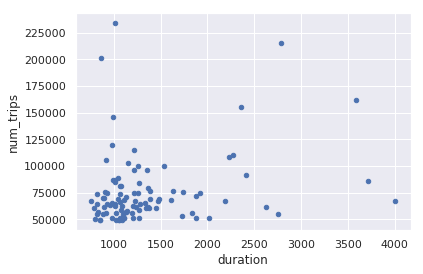

In [39]:
df.plot.scatter('duration', 'num_trips')

### 多忙なサイクル店を見つける
- 貸し借りが同じ店で、かつ一回の時間が10min以下のレンタル数を見積もる

In [40]:
%%bigquery badtrips --project scalable-data-science
WITH all_bad_trips AS(
SELECT 
    start_station_name
    , COUNTIF(duration<600 AND start_station_name = end_station_name) AS bad_trips
    , COUNT(1) AS num_trips
FROM `bigquery-public-data.london_bicycles.cycle_hire`
WHERE EXTRACT(YEAR FROM start_date) =2015
GROUP BY start_station_name
HAVING num_trips > 10
)

SELECT *, bad_trips/num_trips AS fraction_bad FROM all_bad_trips
ORDER BY fraction_bad DESC

In [41]:
badtrips.head()

,start_station_name,bad_trips,num_trips,fraction_bad
0,"Contact Centre, Southbury House",20,48,0.416667
1,"Monier Road, Newham",1,25,0.040000
2,"Aberfeldy Street, Poplar",35,955,0.036649
3,"Ormonde Gate, Chelsea",315,8932,0.035266
4,"Thornfield House, Poplar",28,947,0.029567


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


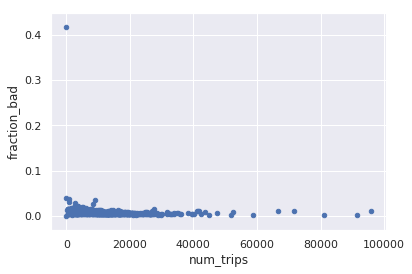

In [42]:
badtrips.plot.scatter('num_trips', 'fraction_bad')

一位の0.4は外れ値だった

### 全体傾向を調べる

(0, 0.05)

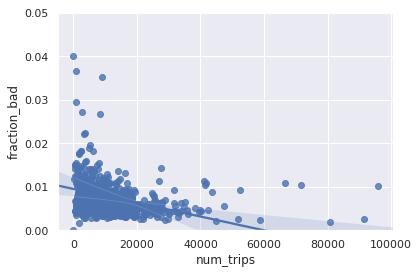

In [43]:
ax = sns.regplot(x='num_trips', y='fraction_bad', data=badtrips)
ax.set_ylim(0,0.05)

貸出が多い店舗のほうが多忙になるような貸出は少ない

### percentileで区切り、bandごとにworst 5を抽出

In [57]:
badtrips['band']=pd.qcut(badtrips['num_trips'], 5)
badtrips_=badtrips.groupby('band').apply(lambda x:x.sort_values('fraction_bad', ascending=False).head())
badtrips_.head()

start_station_name  bad_trips  num_trips  \
band                                                                        
(10.999, 4826.4] 0  Contact Centre, Southbury House         20         48   
                 1              Monier Road, Newham          1         25   
                 2         Aberfeldy Street, Poplar         35        955   
                 4         Thornfield House, Poplar         28        947   
                 5             Langdon Park, Poplar         74       2724   

                    fraction_bad              band  
band                                                
(10.999, 4826.4] 0      0.416667  (10.999, 4826.4]  
                 1      0.040000  (10.999, 4826.4]  
                 2      0.036649  (10.999, 4826.4]  
                 4      0.029567  (10.999, 4826.4]  
                 5      0.027166  (10.999, 4826.4]

## 分析結果を保存

In [59]:
badtrips_ = badtrips_.drop('band', axis=1)
table_id = 'scalable-data-science.bq_ch05.bad_bikes'
job = bq.load_table_from_dataframe(badtrips_, table_id)
job.result()

In [60]:
%%bigquery result --project scalable-data-science
SELECT * FROM `bq_ch05.bad_bikes` LIMIT 10

In [61]:
result.head()

,start_station_name,bad_trips,num_trips,fraction_bad,level_1
0,"Monier Road, Newham",1,25,0.040000,1
1,"Contact Centre, Southbury House",20,48,0.416667,0
2,"Thornfield House, Poplar",28,947,0.029567,4
3,"Aberfeldy Street, Poplar",35,955,0.036649,2
4,"Cumberland Gate, Hyde Park",303,26981,0.011230,76


# TODO foliumを使用して位置を可視化